In [1]:
%matplotlib inline
#%matplotlib notebook

import math
import time
import csv
import numpy as np
import pandas as pd
import scipy
from scipy.signal import find_peaks
import pickle
import random
import matplotlib.pyplot as plt
import os
from os import path
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import lmfit
import statsmodels.api as sm
from functions import *
from exceptions import *

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



##########################################################################################################################
########################################## Define global variables here ##################################################
##########################################################################################################################

A_vs_Thres = {'a': 8.808165681346432e-08, 'b': 3.1949444491357237, 'c': 1.7721138680602374e-05} # parameters for fit of A value vs threshold

calibration_constants = pd.read_csv('./calibration_constants.txt',index_col=0)

In [2]:
###################################################################
# Insert file path below.
#    Software looks for a resets file named "resets_output.txt",
#    and a g4 file named "g4_output.txt" in the directory located
#    at the given file path. If g4_output.txt is not present, will
#    assume the sample is real data and will use saved values for
#    fit functions
###################################################################
   
    
filepath = '../SampleData/' # Change this path



reset_threshold = 0.375#fc
recombination_factor = 1

if os.path.exists(str('%sg4_output.txt'%filepath)) == False:
    raise DataNotPresentError 
sim_data = os.path.exists(str('%sg4_output.txt'%filepath))
if sim_data == True:
    print('g4_output.txt was found in the given directory... Proceeding as simulated data.')
else:
    print('g4_output.txt was not found in the given directory... Proceeding as real data.')


g4_output.txt was found in the given directory... Proceeding as simulated data.


In [3]:
#################################################################################################
# Loading input data
#################################################################################################

print('Unpickling pickled dataframes...')
print('--> resets...')
resets = pd.read_csv('%sresets_output.txt'%filepath,index_col=0)
print('--> unique_active_pixels...')
unique_active_pixels = pd.read_csv('%sUniqueActivePixels.txt'%filepath)


if sim_data == True:
    print('--> g4...')
    g4 = pd.read_csv('%sg4_output.txt'%filepath,index_col=0)

    if resets.event.min() != g4.event.min() or resets.event.max() != g4.event.max():
        raise IndexError('Event numbers in resets and g4 do not correlate')
    events = np.arange(int(resets.event.min()),int(resets.event.max())+1,1)

print("#"*75+"\n"+"RESETS\n"+"#"*75,"\n",resets,"\n\n")

print("#"*75+"\n"+"unique_active_pixels\n"+"#"*75,"\n",unique_active_pixels,"\n\n")

if sim_data == True:
    print("#"*75+"\n"+"G4\n"+"#"*75,"\n",g4,"\n\n")






Unpickling pickled dataframes...
--> resets...
--> unique_active_pixels...
--> g4...
###########################################################################
RESETS
########################################################################### 
         event  pixel_x  pixel_y  reset_time          TSLR  nMCParticles  \
0           0      152      883    0.001577  1.577124e-03             1   
1           0      152      883    0.001578  9.300000e-07             1   
2           0      152      884    0.001577  1.577107e-03             1   
3           0      152      884    0.001578  7.900000e-07             1   
4           0      152      884    0.001579  9.400000e-07             1   
...       ...      ...      ...         ...           ...           ...   
192352      9      349     1087    0.001606  1.606188e-03             2   
192353      9      349     1087    0.001607  9.500000e-07             2   
192354      9      349     1088    0.001606  1.605920e-03             2   
1923


Event Summary
   event        t0  resolution
0    0.0 -0.000035    0.000009
1    1.0 -0.000052    0.000010
2    2.0 -0.000055    0.000010
3    3.0 -0.000073    0.000010
4    4.0 -0.000018    0.000009
5    5.0 -0.000012    0.000009
6    6.0 -0.000084    0.000010
7    7.0 -0.000093    0.000010
8    8.0  0.000008    0.000009
9    9.0 -0.000039    0.000010


Pixels used to determine T0 of each event
   event  pixel_x  pixel_y  Mean_TOA         StDev
0    0.0    286.0    721.0  0.001814  7.745217e-07
1    1.0    288.0     75.0  0.001821  7.794458e-07
2    2.0    284.0   1381.0  0.001815  7.790551e-07
3    3.0    282.0    972.0  0.001814  7.823671e-07
4    4.0    288.0      6.0  0.001820  7.724254e-07
5    5.0    288.0    394.0  0.001820  7.710093e-07
6    6.0    284.0   1474.0  0.001827  7.874269e-07
7    7.0    293.0    668.0  0.001822  7.883437e-07
8    8.0    288.0    233.0  0.001820  7.666986e-07
9    9.0    288.0    911.0  0.001816  7.758762e-07
-45.3 32.5
-4.533245004852721e-05 3.250

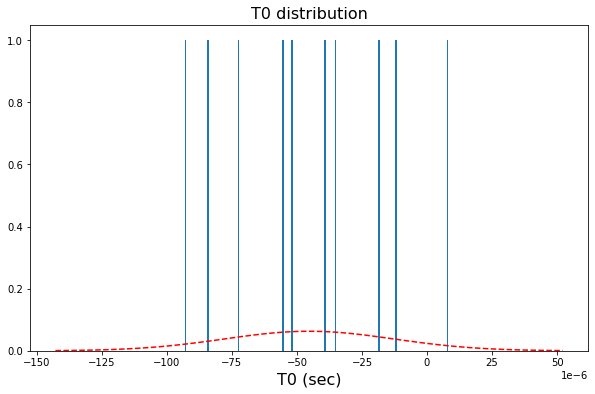

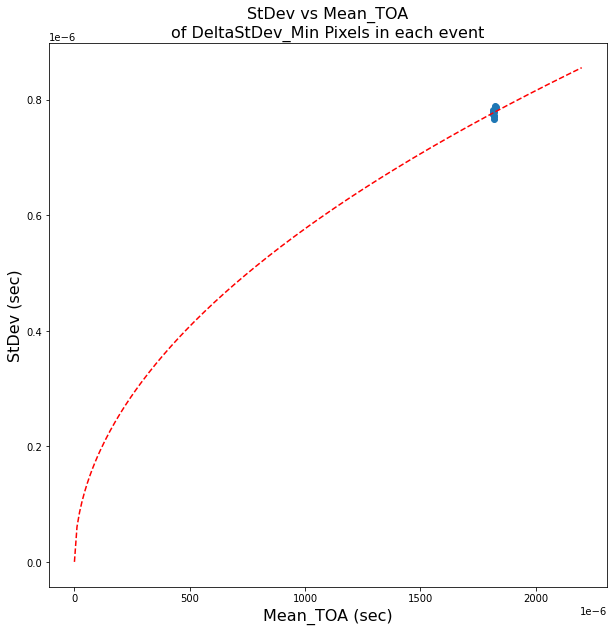

In [14]:
#################################################################################################
# Running DeltaStDev_Min Method
#################################################################################################

nResets_min = 8
A = exponential(reset_threshold,A_vs_Thres['a'],A_vs_Thres['b'],A_vs_Thres['c']) # set the fit function to be the sqrt fn with the coefficient calculate from the A_vs_Thres values

output_eventsummary = pd.DataFrame(columns=['event','t0','resolution'])
chosen_pixels = pd.DataFrame(columns=['event','pixel_x','pixel_y','Mean_TOA','StDev'])
for event in range(0,resets.event.max()+1):
    tmp = unique_active_pixels[(unique_active_pixels.event == event) & (unique_active_pixels.nResets >= nResets_min)].sort_values(by='StDev',ignore_index=True)
    done = False
    while done == False:
        min_pixel = tmp.pixel_x[0]*1e6+tmp.pixel_y[0]
        shift = tmp.Mean_TOA[0] - Quadratic(tmp.StDev[0],1/A**2,0,0)
        tmp = tmp.assign(DeltaStDev = lambda x: x.StDev - Sqrt_Shift(x.Mean_TOA,A,shift))
        tmp = tmp.sort_values(by='DeltaStDev',ignore_index=True)
        new_min_pixel = tmp.pixel_x[0]*1e6+tmp.pixel_y[0]
        if min_pixel == new_min_pixel:
            done = True
            series = pd.Series([tmp.event[0],tmp.Mean_TOA[0]-Quadratic(tmp.StDev[0],1/A**2,0,0),calibration_constants.slope[reset_threshold]*(Quadratic(tmp.StDev[0],1/A**2,0,0)*164800)+calibration_constants.offset[reset_threshold]],index=output_eventsummary.columns)
            output_eventsummary = output_eventsummary.append(series,ignore_index=True)
            series2 = pd.Series([tmp.event[0],tmp.pixel_x[0],tmp.pixel_y[0],tmp.Mean_TOA[0],tmp.StDev[0]],index=chosen_pixels.columns)
            chosen_pixels = chosen_pixels.append(series2,ignore_index=True)
            
print('')

print('Event Summary')
print(output_eventsummary)
print('')
print('')
print('Pixels used to determine T0 of each event')
print(chosen_pixels)

if sim_data == True:
    fig=plt.figure(figsize=(10,6))
    y,x,_ = plt.hist(output_eventsummary.t0,bins=200)
    x = (x[1:]+x[:-1])/2
    lmodel =lmfit.Model(Gaussian)
    
    print(round(output_eventsummary.t0.mean()*1e6,1),round(output_eventsummary.t0.std()*1e6,1))
    lmodel.set_param_hint('mu', value=output_eventsummary.t0.mean(), vary=False)# min=output_eventsummary.t0.min(), max=output_eventsummary.t0.max())
    lmodel.set_param_hint('sigma', value=output_eventsummary.t0.std(), vary=False)#  min=0, max=output_eventsummary.t0.max()-output_eventsummary.t0.min())
    lmodel.set_param_hint('A', value=np.amax(y), min=0, max=np.inf)
    params = lmodel.make_params()
    result = lmodel.fit(data=y, params=params, x=x)
    mu,sigma,A = result.best_values['mu'],result.best_values['sigma'],result.best_values['A']
    #mu,sigma,A = output_eventsummary.t0.mean(),output_eventsummary.t0.std(),np.amax(y)
    print(mu,sigma,A)
    plt.plot(np.linspace(mu-3*sigma,mu+3*sigma,50),Gaussian(np.linspace(mu-3*sigma,mu+3*sigma,50),mu,sigma,A),'r--')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(-6,-6))
    plt.title('T0 distribution')
    plt.xlabel('T0 (sec)')
    plt.show()



    fig=plt.figure(figsize=(10,10))
    plt.scatter(chosen_pixels.Mean_TOA,chosen_pixels.StDev)
    lmodel =lmfit.Model(Sqrt_Shift)
    lmodel.set_param_hint('a', value=A, min=0, max=np.inf)
    lmodel.set_param_hint('c', value=0, vary=False)
    params = lmodel.make_params()
    result = lmodel.fit(data=chosen_pixels.StDev, params=params, x=chosen_pixels.Mean_TOA)
    a,c = result.best_values['a'],result.best_values['c']
    plt.plot(np.linspace(0,2200e-06,200),Sqrt_Shift(np.linspace(0,2200e-06,200),a,c),'r--')
    plt.title('StDev vs Mean_TOA\nof DeltaStDev_Min Pixels in each event')
    plt.xlabel('Mean_TOA (sec)')
    plt.ylabel('StDev (sec)')
    plt.ticklabel_format(axis="x", style="sci", scilimits=(-6,-6))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(-6,-6))
    plt.show()


In [16]:
counter = 0
output_pixel_info = pd.DataFrame(columns=['event','pixel_x','pixel_y','nResets','Mean_TOA','StDev','x','y','z','E'])

print('Processing Event ',end='')
oldevent = -1
for idx,row in unique_active_pixels.iterrows():
    if row.event != oldevent:
        print('%d '%row.event,end='')
        oldevent = row.event
    t0 = float(output_eventsummary.loc[output_eventsummary.event == row.event].t0)
    toa, nResets = row.Mean_TOA, row.nResets
    
    #if nResets < 8:
    #    continue
    
    tof = toa - t0 # calculate time of flight based on t0 and mean time of arrival 
    sigma_est = np.sqrt(2*6.8223*tof/164800**2) # calculate estimated rms of diffusion based on calculated time of flight
    
    tmp = resets[(resets.event == row.event) & (resets.pixel_x == row.pixel_x) & (resets.pixel_y == row.pixel_y)]
    
    kde = sm.nonparametric.KDEUnivariate(tmp.reset_time)
    kde.fit(kernel='gau', bw=sigma_est)
    
    
    dens_prime = []
    dens_primeprime,negdens_primeprime = [],[]
    for i in range(0,len(kde.density)-1):
        dens_prime.append(kde.density[i+1]-kde.density[i])
        if i > 0:
            dens_primeprime.append(dens_prime[i]-dens_prime[i-1])
            negdens_primeprime.append(-(dens_prime[i]-dens_prime[i-1]))
    #print(dens_primeprime)
    #print(negdens_primeprime)
    peaks,_ = find_peaks(negdens_primeprime, height=0)
    
    x = (row.pixel_x*4-2)/10 #determine the true x coordinate of deposits in cm
    y = (row.pixel_x*4-2)/10 #determine the true y coordinate of deposits in cm
    zs_unrounded = 164800*kde.support[peaks] #determine the list of true z coordinates of deposits in cm
    zs = [round(num, 1) for num in zs_unrounded]
    
    Es_unrounded = []
    peaks2,_ = find_peaks(dens_primeprime)
    for i in range(0,len(peaks2)-1):
        E = len(tmp[(tmp.reset_time >= kde.support[peaks2[i]]) & (tmp.reset_time <= kde.support[peaks2[i+1]])].index)
        Es_unrounded.append(E*(6250/42000)*(reset_threshold)*(recombination_factor))
    Es = [round(num, 2) for num in Es_unrounded]
    
    #plt.hist(tmp.reset_time,bins=np.arange(math.floor(tmp.reset_time.min()*1e7-1)/1e7,math.ceil(tmp.reset_time.max()*1e7+1)/1e7,1e-7))
    #plt.plot(kde.support, kde.density/np.amax(kde.density), lw=3)
    #plt.plot(kde.support[1:-1], negdens_primeprime/np.amax(dens_primeprime), lw=3)
    #plt.plot(kde.support[1:-1], dens_primeprime/np.amax(dens_primeprime), ':',lw=3)
    #plt.plot(kde.support[peaks],kde.density[peaks]/np.amax(kde.density),'x')
    #plt.hlines(0,math.floor(tmp.reset_time.min()*1e7-1)/1e7,math.ceil(tmp.reset_time.max()*1e7+1)/1e7,color='r',linestyle='dashed')
    #plt.title('Event %d, Pixel [%d, %d]'%(row.event,row.pixel_x,row.pixel_y))
    #plt.xlabel('time (sec)')
    #plt.ticklabel_format(axis="x", style="sci", scilimits=(-6,-6))
    #plt.show()
    
    series = pd.Series([row.event,row.pixel_x,row.pixel_y,row.nResets,row.Mean_TOA,row.StDev,x,y,zs,Es],index=output_pixel_info.columns)
    output_pixel_info = output_pixel_info.append(series, ignore_index=True)

print('')
print(output_pixel_info)

Processing Event 0 1 2 3 4 5 6 7 8 9 
       event  pixel_x  pixel_y  nResets  Mean_TOA         StDev      x      y  \
0        0.0    152.0    883.0      2.0  0.001578  6.576093e-07   60.6   60.6   
1        0.0    152.0    884.0      4.0  0.001579  1.878208e-06   60.6   60.6   
2        0.0    152.0    885.0      1.0  0.001579           NaN   60.6   60.6   
3        0.0    153.0    882.0      3.0  0.001577  8.507056e-07   61.0   61.0   
4        0.0    153.0    883.0     10.0  0.001578  2.156110e-06   61.0   61.0   
...      ...      ...      ...      ...       ...           ...    ...    ...   
45422    9.0    347.0    985.0      1.0  0.001786           NaN  138.6  138.6   
45423    9.0    348.0   1087.0      1.0  0.001607           NaN  139.0  139.0   
45424    9.0    348.0   1088.0      1.0  0.001607           NaN  139.0  139.0   
45425    9.0    349.0   1087.0      2.0  0.001607  6.717514e-07  139.4  139.4   
45426    9.0    349.0   1088.0      3.0  0.001607  7.052895e-07  139.4 

In [17]:
output_eventsummary.to_csv('%sEventSummary.txt'%filepath)
output_pixel_info.to_csv('%sReconstruction.txt'%filepath)